# Making Gas Density Radial Profiles of all Galaxies in the VERTICO Sample

Note that there are only 36 galaxies in this analysis because several VERTICO galaxies are
not in the NGVS footprint and I got the NGC 4189 flag map too late and NGC 4606's flag map
is too intrusive.


In [1]:
%cd "/arc/home/IsaacCheng/coop_f2021/galaxies/stellar_mass_densities/"

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import dill
import astropy.coordinates as coord
import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
# 
# Load my own packages
# 
import sys
sys.path.append("/arc/home/IsaacCheng/coop_f2021/packages")
import fits_utils as fu
import plot_utils as pu
import radial_profile_utils as rpu
from radial_profile import RadialProfile

/arc/home/IsaacCheng/coop_f2021/galaxies/stellar_mass_densities


In [2]:
GALAXIES = [
    "IC3392",
    # "NGC4189",  # ignored flag map, but bad results
    "NGC4192",
    "NGC4216",  # has unflagged foreground star
    "NGC4222",
    "NGC4254",
    "NGC4294",
    "NGC4298",
    "NGC4299",
    "NGC4302",
    "NGC4321",
    "NGC4330",
    "NGC4351",
    "NGC4380",
    "NGC4383",
    "NGC4388",
    "NGC4396",
    "NGC4402",
    "NGC4405",
    "NGC4419",
    "NGC4424",
    "NGC4450",
    "NGC4501",
    "NGC4522",
    "NGC4532",
    "NGC4535",
    "NGC4548",
    "NGC4567",
    "NGC4568",
    "NGC4569",
    "NGC4579",
    "NGC4580",
    # "NGC4606",  # flag map too intrusive
    "NGC4607",
    "NGC4651",
    "NGC4654",
    "NGC4689",
    "NGC4694",
]
INCLINATIONS = [
    68,
    # 42,  # ignored flag map, but bad results
    83,
    90,  # has unflagged foreground star
    90,
    39,
    74,
    52,
    14,
    90,
    32,
    90,
    48,
    61,
    56,
    83,
    83,
    80,
    46,
    74,
    61,
    51,
    65,
    82,
    64,
    48,
    37,
    49,
    70,
    69,
    40,
    46,
    # 69,  # flag map too intrusive
    90,
    53,
    61,
    38,
    62,
]  # degrees
POSITION_ANGLES = [
    219,
    # 70,  # ignored flag map, but bad results
    333,
    20,  # has unflagged foreground star
    238,
    243,
    151,
    132,
    128,
    356,
    280,
    238,
    251,
    158,
    17,
    271,
    304,
    270,
    18,
    131,
    274,
    170,
    320,
    35,
    159,
    12,
    318,
    251,
    211,
    203,
    273,
    337,
    # 38,  # flag map too intrusive
    2,
    75,
    300,
    341,
    323
]  # degrees

# N.B. "high inclination" means inclination >= 80 degrees
HIGH_I_GALAXIES = [
    "NGC4192",
    "NGC4216",
    "NGC4222",
    "NGC4302",
    "NGC4330",
    "NGC4388",
    "NGC4396",
    "NGC4402",
    "NGC4522",
    "NGC4607",
]
HIGH_I_INCLINATIONS = [
    83,
    90,
    90,
    90,
    90,
    83,
    83,
    80,
    82,
    90,
]  # degrees
HIGH_I_POSITION_ANGLES = [
    333,
    20,
    238,
    356,
    238,
    271,
    304,
    270,
    35,
    2
]  # degrees

HIGH_I_HEIGHTS_ARCSEC = [
    80,
    60,
    25,
    55,
    38,
    65,
    43,
    45,
    40,
    70,
]  # arcsec, for radial profiles


# Determine height of rectangles for high-i galaxies


In [3]:
def find_height(galaxy, i, pa, min_width, height, i_threshold=80, snr_target=50):
    #
    # Load CO data for reference
    #
    if galaxy == "NGC4321":  # no 9 arcsec data since native is 10 arcsec
        Ico_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3.1/native/{galaxy}/{galaxy}_7m+tp_co21_pbcorr_round_mom0_Kkms-1.fits"
    else:
        Ico_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/{galaxy}/{galaxy}_7m+tp_co21_pbcorr_9as_round_mom0_Kkms-1.fits"
    Ico_data, co_header = fits.getdata(Ico_path, header=True)
    co_wcs = WCS(co_header)
    centre = co_wcs.pixel_to_world(Ico_data.shape[1] / 2, Ico_data.shape[0] / 2)
    include_bad = True if i < i_threshold else False  # only include NaNs if low-i galaxy
    #
    # Load NGVS data
    #
    galpath = f"/arc/home/IsaacCheng/coop_f2021/galaxies/{galaxy}/"
    with open(galpath + f"{galaxy}_vorbin_SNR{snr_target}_ugizBinned.pkl", "rb") as f:
        file = dill.load(f)
        px_per_bin = file["px_per_bin"]
        # uband_data = file["uband_signal"] / px_per_bin
        # gband_data = file["gband_signal"] / px_per_bin
        iband_data = file["iband_signal"] / px_per_bin
        vorbin_wcs = file["wcs"]
        vorbin_wcs.array_shape = file["wcs_array_shape"]
        file = None  # free memory
    galaxy_rp = RadialProfile(iband_data, centre, i, pa, noise=None)
    galaxy_rp = galaxy_rp.calc_radial_profile(
        i_threshold=i_threshold,
        n_annuli=1,
        wcs=vorbin_wcs,
        min_width=min_width,
        include_bad=include_bad,
        func="mean",
        is_radio=False,
        high_i_height=height,
        bootstrap_errs=False,
    )
    fig, ax = plt.subplots(subplot_kw={"projection": vorbin_wcs})
    img = ax.imshow(galaxy_rp.data, cmap="magma_r", norm=mpl.colors.LogNorm())
    cbar = fig.colorbar(img)
    ax.plot(*vorbin_wcs.world_to_pixel(centre), "co", markersize=2, zorder=20)  # mark centre
    pu.add_annuli_RadialProfile(ax, galaxy_rp, alpha_coeff=0.25, zorder=10, ls="-", edgecolor="k", fc="k", lw=1) # add rectangle
    ax.contour(  # overlay CO contours
        Ico_data,
        transform=ax.get_transform(co_wcs),
        levels=range(2),
        colors="w",
        linewidths=1,
    )
    ax.set_aspect("equal")
    ax.grid(False)
    ax.set_xlabel("RA (J2000)")
    ax.set_ylabel("Dec (J2000)")
    ax.set_xlim(0, galaxy_rp.data.shape[1])
    ax.set_ylim(0, galaxy_rp.data.shape[0])
    ax.set_title(galaxy)
    plt.show()
    #
    # RGB plot
    #
    # "red" channel (i-band)
    iband_path = f"/arc/home/IsaacCheng/coop_f2021/ngvs_data/{galaxy}/{galaxy}_i_data.fits"
    # "green" channel (g-band)
    gband_path = f"/arc/home/IsaacCheng/coop_f2021/ngvs_data/{galaxy}/{galaxy}_g_data.fits"
    # "blue" channel (u-band)
    uband_path = f"/arc/home/IsaacCheng/coop_f2021/ngvs_data/{galaxy}/{galaxy}_u_data.fits"
    iband_data_uncut, iband_header_uncut = fits.getdata(iband_path, header=True)
    gband_data_uncut, gband_header_uncut = fits.getdata(gband_path, header=True)
    uband_data_uncut, uband_header_uncut = fits.getdata(uband_path, header=True)
    iband_data, iband_wcs = fu.cutout_to_target(
        iband_data_uncut, WCS(iband_header_uncut), Ico_data, co_wcs
    )
    gband_data, _ = fu.cutout_to_target(
        gband_data_uncut, WCS(gband_header_uncut), Ico_data, co_wcs
    )
    uband_data, _ = fu.cutout_to_target(
        uband_data_uncut, WCS(uband_header_uncut), Ico_data, co_wcs
    )
    rgb_data = pu.lognorm_median(iband_data, gband_data, uband_data, a=1000, norm_factor=1000)
    fig, ax = plt.subplots(subplot_kw={"projection": iband_wcs})
    img = ax.imshow(rgb_data)
    ax.plot(*iband_wcs.world_to_pixel(centre), "ro", markersize=2, zorder=20)  # mark centre
    pu.add_annuli_RadialProfile(ax, galaxy_rp, alpha_coeff=0.25, zorder=10, ls="-", edgecolor="w", fc="w", lw=1) # add rectangle
    ax.contour(  # overlay CO contours
        Ico_data,
        transform=ax.get_transform(co_wcs),
        levels=range(2),
        colors="w",
        linewidths=1,
    )
    ax.set_aspect("equal")
    ax.grid(False)
    ax.set_xlabel("RA (J2000)")
    ax.set_ylabel("Dec (J2000)")
    ax.set_xlim(0, iband_data.shape[1])
    ax.set_ylim(0, iband_data.shape[0])
    ax.set_title(galaxy)
    ax.tick_params(color="w")
    plt.show()

In [ ]:
# find_height(HIGH_I_GALAXIES[0], HIGH_I_INCLINATIONS[0], HIGH_I_POSITION_ANGLES[0], min_width=300*u.arcsec, height=80*u.arcsec)
# find_height(HIGH_I_GALAXIES[1], HIGH_I_INCLINATIONS[1], HIGH_I_POSITION_ANGLES[1], min_width=300*u.arcsec, height=60*u.arcsec)
# find_height(HIGH_I_GALAXIES[2], HIGH_I_INCLINATIONS[2], HIGH_I_POSITION_ANGLES[2], min_width=300*u.arcsec, height=25*u.arcsec)
# find_height(HIGH_I_GALAXIES[3], HIGH_I_INCLINATIONS[3], HIGH_I_POSITION_ANGLES[3], min_width=300*u.arcsec, height=55*u.arcsec)
# find_height(HIGH_I_GALAXIES[4], HIGH_I_INCLINATIONS[4], HIGH_I_POSITION_ANGLES[4], min_width=300*u.arcsec, height=38*u.arcsec)
# find_height(HIGH_I_GALAXIES[5], HIGH_I_INCLINATIONS[5], HIGH_I_POSITION_ANGLES[5], min_width=300*u.arcsec, height=65*u.arcsec)
# find_height(HIGH_I_GALAXIES[6], HIGH_I_INCLINATIONS[6], HIGH_I_POSITION_ANGLES[6], min_width=300*u.arcsec, height=43*u.arcsec)
# find_height(HIGH_I_GALAXIES[7], HIGH_I_INCLINATIONS[7], HIGH_I_POSITION_ANGLES[7], min_width=300*u.arcsec, height=45*u.arcsec)
# find_height(HIGH_I_GALAXIES[8], HIGH_I_INCLINATIONS[8], HIGH_I_POSITION_ANGLES[8], min_width=300*u.arcsec, height=40*u.arcsec)
# find_height(HIGH_I_GALAXIES[9], HIGH_I_INCLINATIONS[9], HIGH_I_POSITION_ANGLES[9], min_width=300*u.arcsec, height=70*u.arcsec)

Min width (pixels): 1614.8889367930403
Info: Inclination greater than i_threshold. Fitting rectangles along major axis instead of ellipses/annuli
Height (pixels): 430.6370498114774


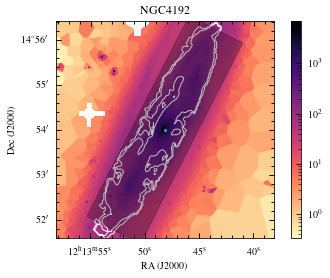

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


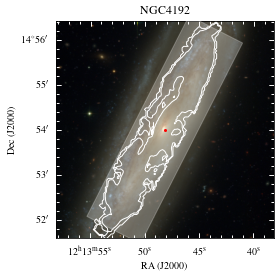

Min width (pixels): 1614.6530772234796
Info: Inclination greater than i_threshold. Fitting rectangles along major axis instead of ellipses/annuli
Height (pixels): 322.9306154446959


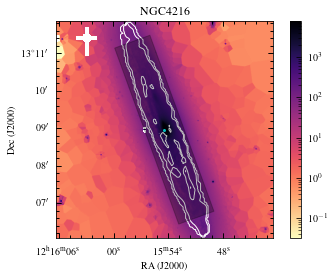

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


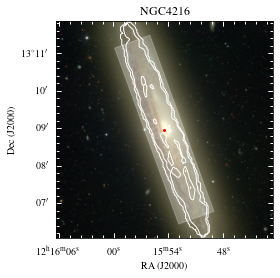

Min width (pixels): 1614.6530772234796
Info: Inclination greater than i_threshold. Fitting rectangles along major axis instead of ellipses/annuli
Height (pixels): 134.55442310195662


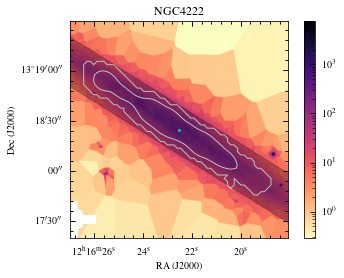

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


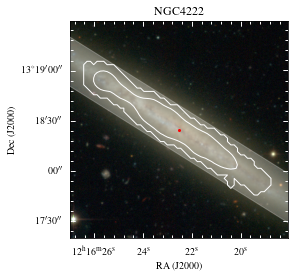

Min width (pixels): 1614.7143122976504
Info: Inclination greater than i_threshold. Fitting rectangles along major axis instead of ellipses/annuli
Height (pixels): 296.0309572545693


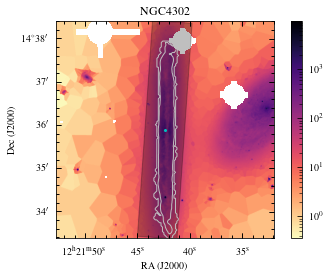

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


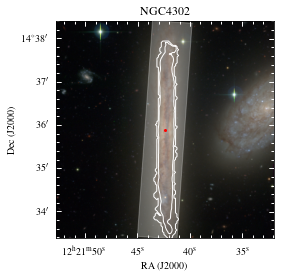

Min width (pixels): 1615.3453699674465
Info: Inclination greater than i_threshold. Fitting rectangles along major axis instead of ellipses/annuli
Height (pixels): 204.6104135292099


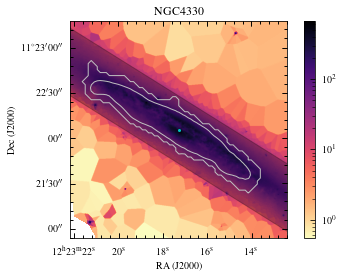

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


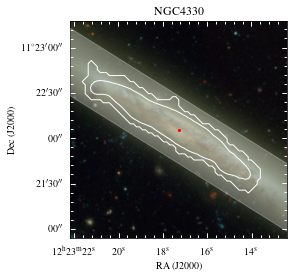

Min width (pixels): 1614.2853108601334
Info: Inclination greater than i_threshold. Fitting rectangles along major axis instead of ellipses/annuli
Height (pixels): 349.76181735302896


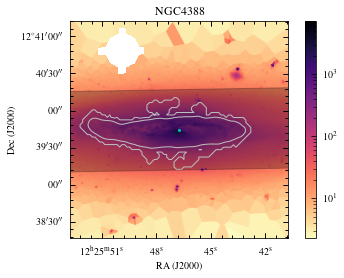

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


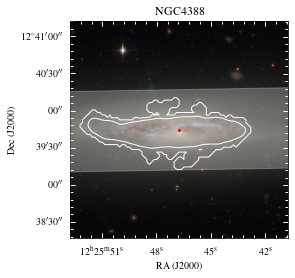

Min width (pixels): 1614.748801386336
Info: Inclination greater than i_threshold. Fitting rectangles along major axis instead of ellipses/annuli
Height (pixels): 231.44732819870816


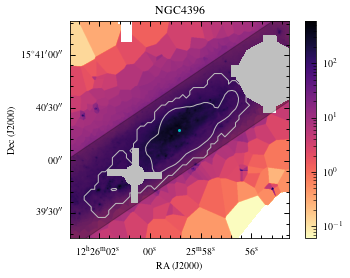

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


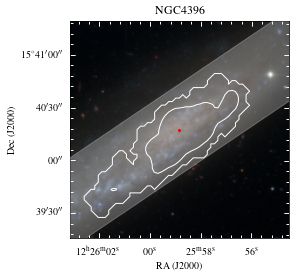

Min width (pixels): 1614.2853108601334
Info: Inclination greater than i_threshold. Fitting rectangles along major axis instead of ellipses/annuli
Height (pixels): 242.14279662902004


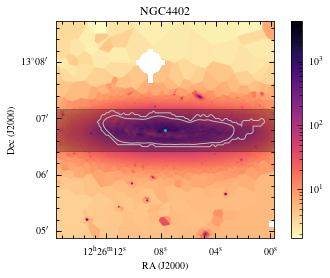

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


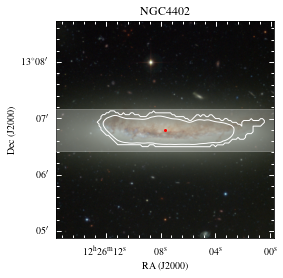

Min width (pixels): 1614.767811220389
Info: Inclination greater than i_threshold. Fitting rectangles along major axis instead of ellipses/annuli
Height (pixels): 215.30237482938517


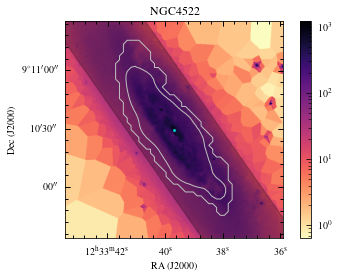

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


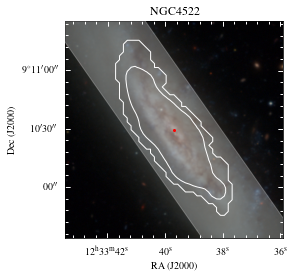

Min width (pixels): 1615.5030404662857
Info: Inclination greater than i_threshold. Fitting rectangles along major axis instead of ellipses/annuli
Height (pixels): 376.9507094421333


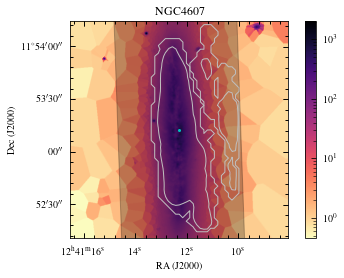

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


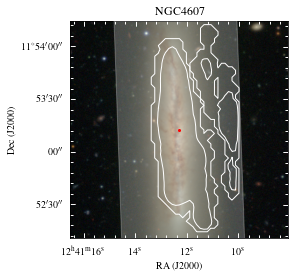

In [4]:
for galaxy, i, pa, high_i_height in zip(HIGH_I_GALAXIES, HIGH_I_INCLINATIONS, HIGH_I_POSITION_ANGLES, HIGH_I_HEIGHTS_ARCSEC):
    find_height(galaxy, i, pa, min_width=300*u.arcsec, height=high_i_height*u.arcsec)